<a href="https://colab.research.google.com/github/Yuri-Vlasqz/Imersao_de_dados_Alura_2022/blob/main/Imers%C3%A3o_de_dados_Alura_(2022)_aulas_%2B_desafios_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **4º Imersão de dados Alura (2022)**
**Aula 5**

Instrutores:
---
- Thiago Gonçalves - Machine Learning Engineering Manager na Creditas
- Vivian Yamassaki - Lead Data Scientist I na Creditas
- Paulo Silveira - Co-fundador e CEO da Alura
___
Autor: Yuri Velasquez
---
[Github](https://github.com/Yuri-Vlasqz)

___
Datasets utilizado:
- [imoveis_tratados_manual](https://drive.google.com/file/d/1HeAS1SEHgxoC2rwhqOu04IJZ3OzOm1Xa/view?usp=sharing) : outliers de dados tratados por contextos gráficos e estatísticos
- [imoveis_tratados](https://drive.google.com/file/d/19b6mo0S4TcplwlFInBZKtk7wjkJc62o7/view?usp=sharing) : dados tratados por algoritmos que detectam outliers uni e multi dimencionais

In [1]:
# Instalação de bibliotecas
!pip install geopandas

# Importação de blibliotecas
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, classification_report
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import statsmodels.api as sm

from shapely.geometry import Point
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import pandas as pd
import numpy as np
import time

# Parâmetros Globais
pd.set_option('display.float_format', lambda x: '%.2f' %x)
pd.set_option("max_columns", None)
sns.set()

# Link Datasets
path = "/content/drive/MyDrive/Imersão_de_dados_Alura_(2022)/Datasets gerados/imoveis_tratados.csv"
path_manual = "/content/drive/MyDrive/Imersão_de_dados_Alura_(2022)/Datasets gerados/imoveis_tratados_manual.csv"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 9.1 MB/s 
     |████████████████████████████████| 6.3 MB 44.4 MB/s 
     |████████████████████████████████| 16.7 MB 40.6 MB/s 


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Funções

In [2]:
def lr_model(X,  Y, tittle='Linear Regression Model'):

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25, random_state = 54)
    lr = LinearRegression()  # positive=True?
    lr.fit(X_train, Y_train)

    Y_predict_test = lr.predict(X_test)
    Y_predict_train = lr.predict(X_train)

    mae_test = mean_absolute_error(Y_test, Y_predict_test)
    r2_test = r2_score(Y_test, Y_predict_test)
    mae_train = mean_absolute_error(Y_train, Y_predict_train)
    r2_train = r2_score(Y_train, Y_predict_train)
    print(f" ----- {tittle} -----\n")
    print(f"\Test Statistics\ \n - Mean Absolute Error: {mae_test}\n - R2-score: {r2_test}\n")
    print(f"\Train Statistics\ \n - Mean Absolute Error: {mae_train}\n - R2-score: {r2_train}")

    plt.figure(figsize=(8, 8))
    sns.scatterplot(x=Y_test, y=Y_predict_test)

    return

In [3]:
def gbr_model(X,Y):


    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25, random_state = 54)

    # best --> n_estimators=2500+, learning_rate=0.2, min_samples_split=2, max_depth=10, random_state=0
    params = {
        "n_estimators": 500,
        "max_depth": 8,
        "learning_rate": 0.05,
        "loss": "squared_error",
        "random_state": 0
    }
    reg = GradientBoostingRegressor(**params)
    reg.fit(X_train, y_train)

    print(reg)
    print(f"mean squared error: {mean_squared_error(y_test, reg.predict(X_test))}")
    print(f"score: {reg.score(X_test, y_test)}")

    # Scatter plot Test x Predict
    #plt.figure(figsize=(6, 6))
    #sns.scatterplot(x=y_test, y=reg.predict(X_test))
    #plt.show()

    # Plot training deviance
    test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
    for i, y_pred in enumerate(reg.staged_predict(X_test)):
        test_score[i] = reg.loss_(y_test, y_pred)

    fig = plt.figure(figsize=(6, 6))
    plt.subplot(1, 1, 1)
    plt.title("Deviance")
    plt.plot(
        np.arange(params["n_estimators"]) + 1,
        reg.train_score_,
        "b-",
        label="Training Set Deviance",
    )
    plt.plot(
        np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
    )
    plt.legend(loc="upper right")
    plt.xlabel("Boosting Iterations")
    plt.ylabel("Deviance")
    fig.tight_layout()
    plt.show()


    # Feature Importance bar plot
    feature_importance = reg.feature_importances_
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + 0.5
    fig = plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.barh(pos, feature_importance[sorted_idx], align="center")
    plt.yticks(pos, np.array(X.columns.to_list())[sorted_idx])
    plt.title("Feature Importance (MDI)")

    result = permutation_importance(
        reg, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
    )
    sorted_idx = result.importances_mean.argsort()
    plt.subplot(1, 2, 2)
    plt.boxplot(
        result.importances[sorted_idx].T,
        vert=False,
        labels=np.array(X.columns.to_list())[sorted_idx],
    )
    plt.title("Permutation Importance (test set)")
    fig.tight_layout()
    plt.show()

    return

In [4]:
def corr_matrix(data, cmap='divergent'):
    """
    It reads a dataframe and show a Lower Triangle Correlation Matrix.

    Parameters
    ----------
    data: dataframe
        Tabela ou colunas da tabela a serem correlacionadas (tipo numerico)
    cmap: string 
        Representa o mapa de cores (default='divergent' or 'sequencial')
        
    Returns
    -------
    matriz: None
        Mostra a matriz de correlação na chamada da função
        
    Examples
    --------
    corr_matrix(data[lista_colunas], 'cmap')
    """    

    # Lower Triangle Correlation Matrix
    corr_df = data.corr()
    corr_shape = corr_df.shape
    tri_df = corr_df.where(np.tril(np.ones(corr_shape)).astype(bool))

    # Figure Ploting parameters
    if cmap == "sequential":
        cmap = "rocket"
    else:
        cmap = "coolwarm"

    plt.figure(figsize=(corr_shape))
    sns.heatmap(tri_df, linewidths=0.5, annot=True, cmap=cmap)
    plt.title('Correlation Matrix')
    plt.xticks(rotation=40, ha='right')

    return

## Aula 5: Modelo Preditivo

![lr](https://miro.medium.com/max/700/0*NrINywH3bS8-po_T.gif "Linear Regression")

In [5]:
# Lendo dados de imoveis tratados manualmente
imoveis_drive = pd.read_csv(path_manual)
imoveis_tratados_manual = imoveis_drive.drop(imoveis_drive.columns[[0]], axis=1)
display(imoveis_tratados_manual.head(), imoveis_tratados_manual.shape)

,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Valor,Preco_m2,rua_e_bairro,cep,latitude,longitude,Point,setor_censo,Cod_distrito,Nome_do_distrito,Situacao_setor,Tipo_setor,V001,V002,V003,V004,V005,V006,V007,V008,V009,V010,V011,V012
0,"Avenida Itacira, 255",Planalto Paulista,São Paulo,1000,4,8,6,7000000.00,7000.00,avenida itacira - planalto paulista,4061000.00,-23.62,-46.65,POINT (-46.6481622 -23.6157934),355030877000067.00,355030877.00,SAÚDE,1.00,0.00,164.00,437.00,2.66,2.04,3158.96,22210644.93,5570.65,25770816.97,2096.19,13029851.56,3930.35,17241576.74
1,"Rua Aurelia Perez Alvarez, 42",Jardim dos Estados,São Paulo,496,4,4,4,3700000.00,7459.68,rua aurelia perez alvarez - jardim dos estados,4642020.00,-23.64,-46.69,POINT (-46.6883114 -23.6409612),355030871000023.00,355030871.00,SANTO AMARO,1.00,0.00,136.00,425.00,3.13,1.96,7600.44,36778930.17,7890.53,35886906.64,4149.00,26760682.90,6063.92,27502674.90
2,Rua Alba Valdez,Jardim Reimberg,São Paulo,125,4,3,2,380000.00,3040.00,rua alba valdez - jardim reimberg,4845200.00,-23.75,-46.70,POINT (-46.6958895 -23.75299),355030830000050.00,355030830.00,GRAJAÚ,1.00,0.00,142.00,493.00,3.47,3.06,805.13,769188.78,1011.75,757433.42,518.77,426672.78,858.51,414378.88
3,"Rua Tobias Barreto, 195",Mooca,São Paulo,100,3,2,2,540000.00,5400.00,rua tobias barreto - mooca,3176000.00,-23.55,-46.59,POINT (-46.5881729 -23.5499597),355030808000050.00,355030808.00,BELÉM,1.00,0.00,156.00,468.00,3.00,1.99,2338.05,7826370.15,2447.89,7925839.76,1543.29,4646566.16,1909.04,5050712.69
4,Rua Graham Bell,Santo Amaro,São Paulo,440,4,4,6,1980000.00,4500.00,rua graham bell - santo amaro,4737030.00,-23.59,-46.76,POINT (-46.7600773 -23.5937964),355030865000169.00,355030865.00,RAPOSO TAVARES,1.00,0.00,107.00,376.00,3.51,2.31,1026.36,272168.67,1143.96,167733.64,735.67,367088.08,1086.94,159622.46


(4879, 31)

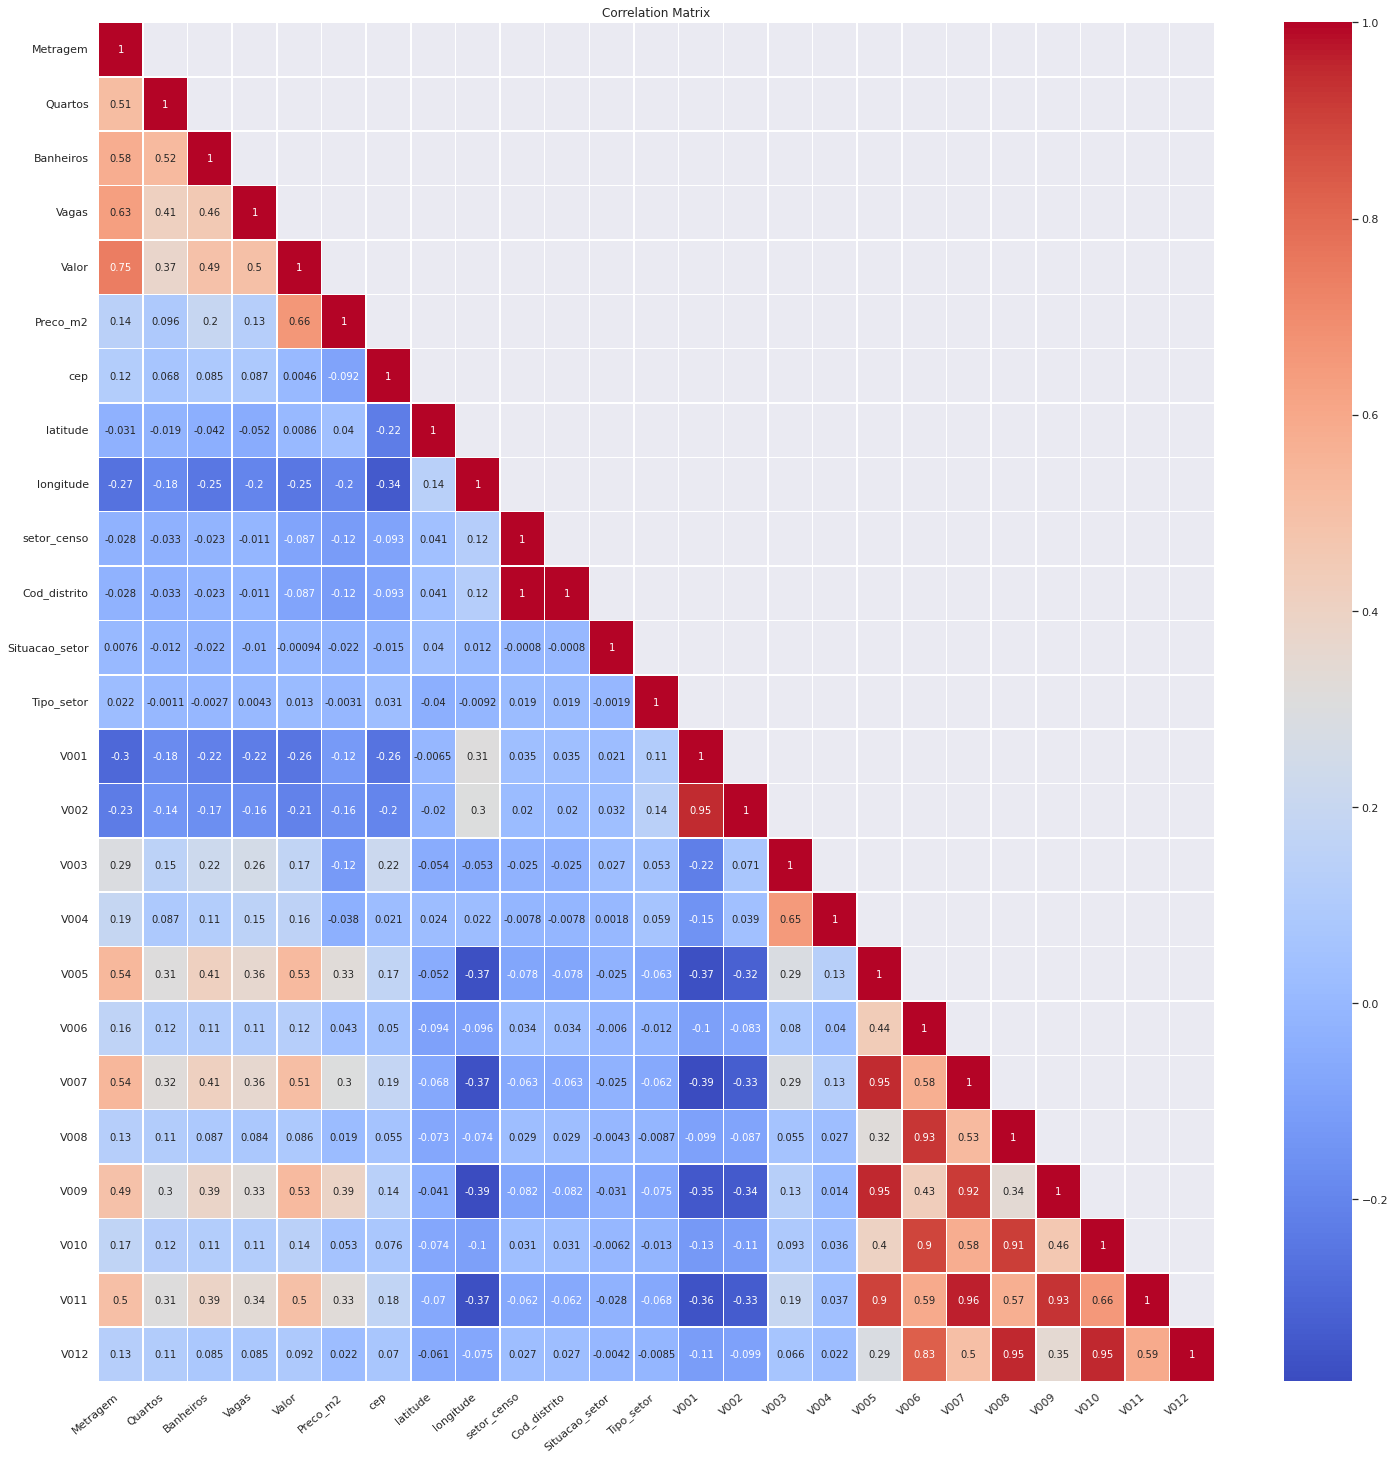

In [ ]:
corr_matrix(imoveis_tratados_manual)

In [6]:
# Lendo dados de imoveis tratados por algoritmo
path = "/content/drive/MyDrive/Imersão_de_dados_Alura_(2022)/Datasets gerados/imoveis_tratados.csv"
imoveis_drive = pd.read_csv(path)
imoveis_tratados = imoveis_drive.drop(imoveis_drive.columns[[0]], axis=1)
display(imoveis_tratados.head(), imoveis_tratados.shape)

,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Valor,Preco_m2,rua_e_bairro,cep,latitude,longitude,Point,setor_censo,Cod_distrito,Nome_do_distrito,Situacao_setor,Tipo_setor,V001,V002,V003,V004,V005,V006,V007,V008,V009,V010,V011,V012
0,"Avenida Itacira, 255",Planalto Paulista,São Paulo,1000,4,8,6,7000000.00,7000.00,avenida itacira - planalto paulista,4061000.00,-23.62,-46.65,POINT (-46.6481622 -23.6157934),355030877000067.00,355030877.00,SAÚDE,1.00,0.00,164.00,437.00,2.66,2.04,3158.96,22210644.93,5570.65,25770816.97,2096.19,13029851.56,3930.35,17241576.74
1,"Rua Aurelia Perez Alvarez, 42",Jardim dos Estados,São Paulo,496,4,4,4,3700000.00,7459.68,rua aurelia perez alvarez - jardim dos estados,4642020.00,-23.64,-46.69,POINT (-46.6883114 -23.6409612),355030871000023.00,355030871.00,SANTO AMARO,1.00,0.00,136.00,425.00,3.13,1.96,7600.44,36778930.17,7890.53,35886906.64,4149.00,26760682.90,6063.92,27502674.90
2,Rua Alba Valdez,Jardim Reimberg,São Paulo,125,4,3,2,380000.00,3040.00,rua alba valdez - jardim reimberg,4845200.00,-23.75,-46.70,POINT (-46.6958895 -23.75299),355030830000050.00,355030830.00,GRAJAÚ,1.00,0.00,142.00,493.00,3.47,3.06,805.13,769188.78,1011.75,757433.42,518.77,426672.78,858.51,414378.88
3,"Rua Tobias Barreto, 195",Mooca,São Paulo,100,3,2,2,540000.00,5400.00,rua tobias barreto - mooca,3176000.00,-23.55,-46.59,POINT (-46.5881729 -23.5499597),355030808000050.00,355030808.00,BELÉM,1.00,0.00,156.00,468.00,3.00,1.99,2338.05,7826370.15,2447.89,7925839.76,1543.29,4646566.16,1909.04,5050712.69
4,Rua Graham Bell,Santo Amaro,São Paulo,440,4,4,6,1980000.00,4500.00,rua graham bell - santo amaro,4737030.00,-23.59,-46.76,POINT (-46.7600773 -23.5937964),355030865000169.00,355030865.00,RAPOSO TAVARES,1.00,0.00,107.00,376.00,3.51,2.31,1026.36,272168.67,1143.96,167733.64,735.67,367088.08,1086.94,159622.46


(4794, 31)

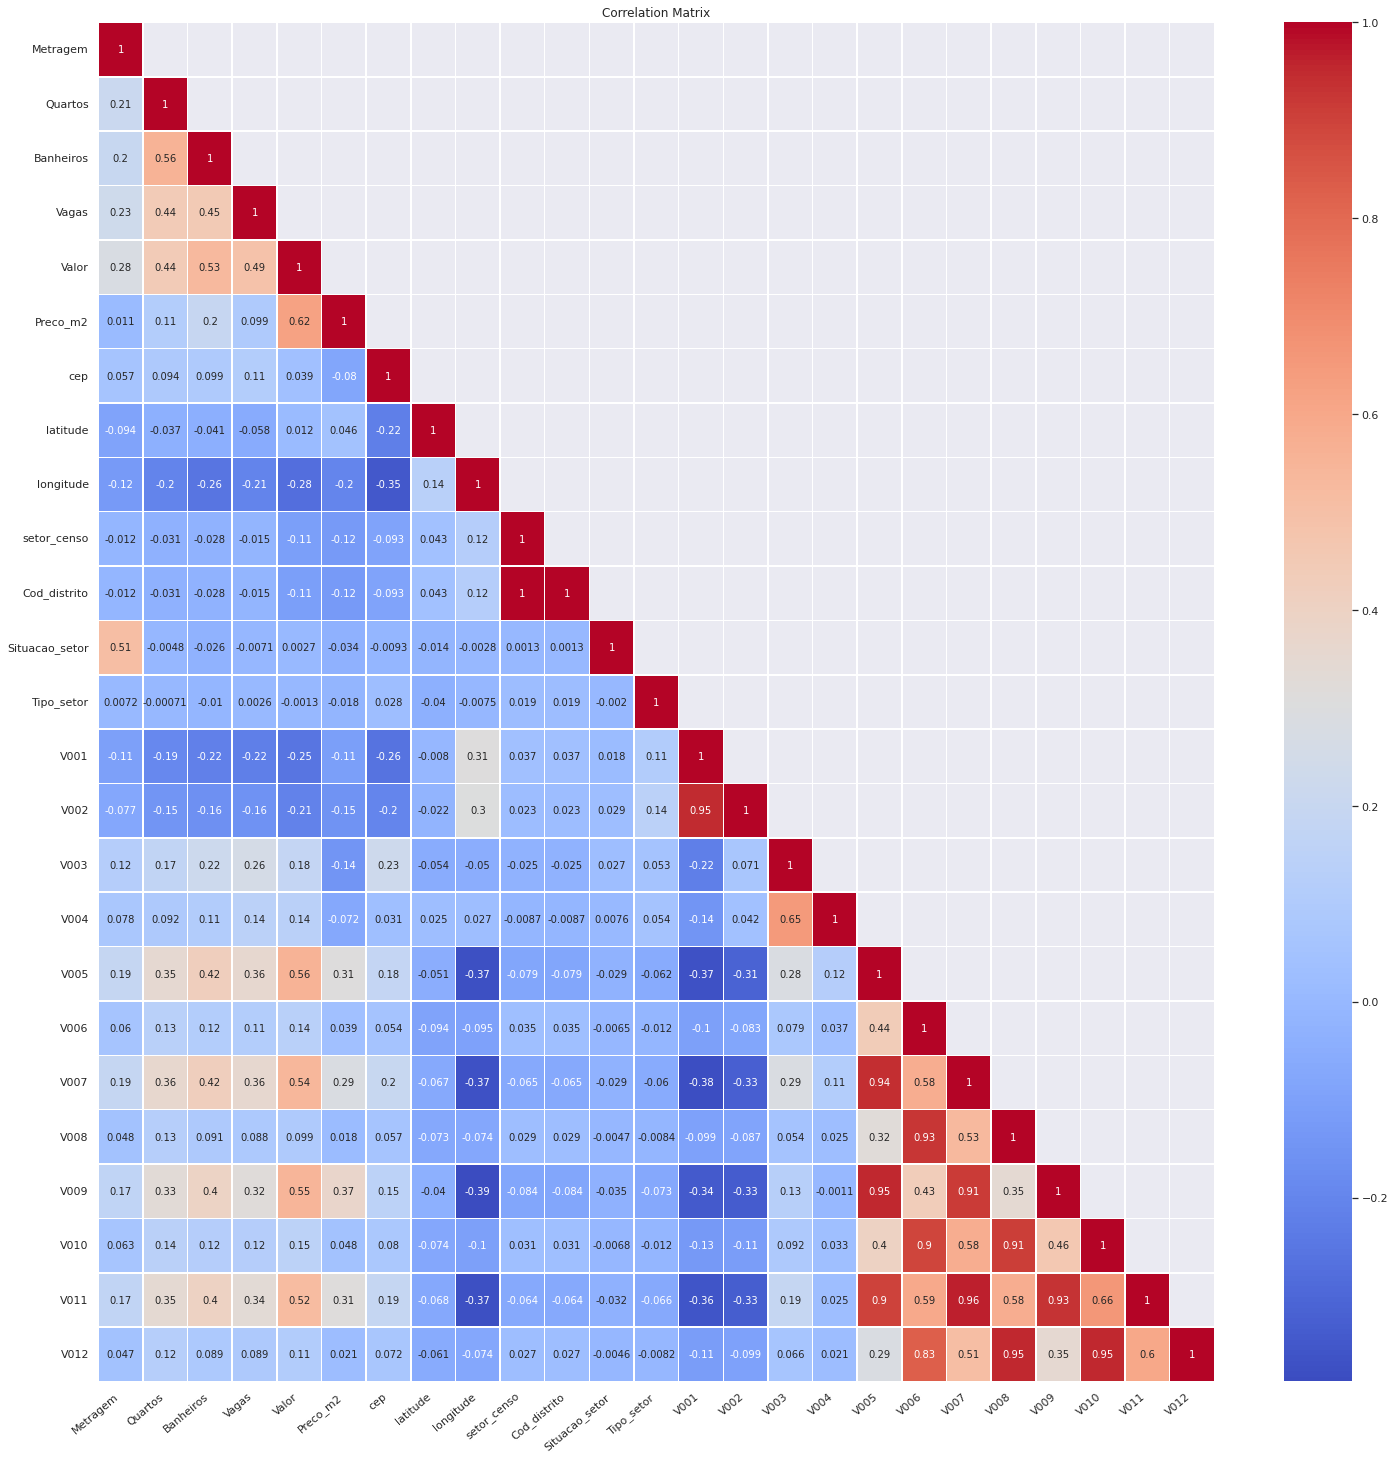

In [ ]:
corr_matrix(imoveis_tratados)

 ----- Modelo com Variaveis Originais (Manual) -----

\Test Statistics\ 
 - Mean Absolute Error: 1058753.4133022123
 - R2-score: 0.5500347827208194

\Train Statistics\ 
 - Mean Absolute Error: 1020450.1365453325
 - R2-score: 0.5669420232498616


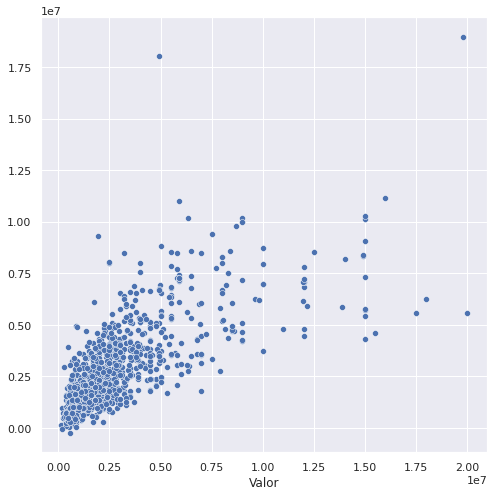

In [ ]:
lr_model(X=imoveis_tratados_manual[['Metragem','Quartos','Banheiros','Vagas']],
         Y=imoveis_tratados_manual["Valor"], tittle='Modelo com Variaveis Originais (Manual)')

In [ ]:
X=imoveis_tratados_manual[['Metragem','Quartos','Banheiros','Vagas']]
X.columns.to_list()

['Metragem', 'Quartos', 'Banheiros', 'Vagas']

 ----- Modelo com Variaveis Originais (Algoritmo) -----

\Test Statistics\ 
 - Mean Absolute Error: 1212546.2771112411
 - R2-score: 0.3666769189902179

\Train Statistics\ 
 - Mean Absolute Error: 1155193.8312409834
 - R2-score: 0.3934975501915412


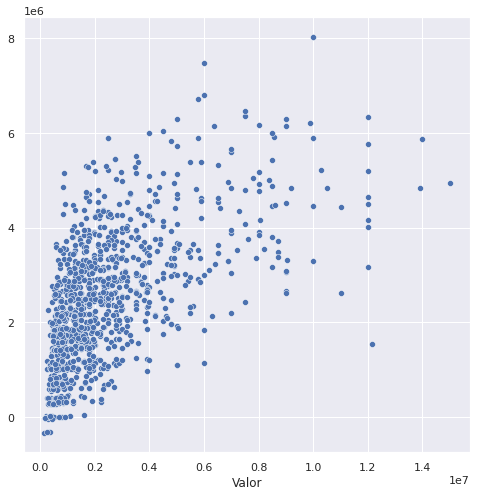

In [ ]:
lr_model(X=imoveis_tratados[['Metragem','Quartos','Banheiros','Vagas']],
         Y=imoveis_tratados["Valor"], tittle='Modelo com Variaveis Originais (Algoritmo)')

 ----- Modelo com dados IBGE (Manual) -----

\Test Statistics\ 
 - Mean Absolute Error: 992908.9597952354
 - R2-score: 0.5906031752414656

\Train Statistics\ 
 - Mean Absolute Error: 957949.192795459
 - R2-score: 0.6017138745635102


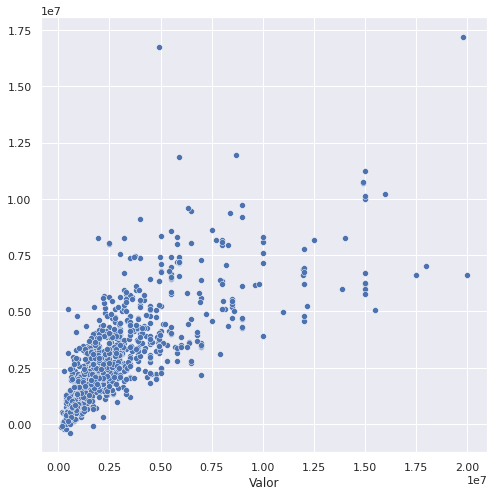

In [ ]:
lr_model(X=imoveis_tratados_manual[['Metragem', 'Quartos', 'Banheiros', 'Vagas','V001','V007', 'V009']],
         Y=imoveis_tratados_manual["Valor"], tittle='Modelo com dados IBGE (Manual)')

 ----- Modelo com dados IBGE (Algoritmo) -----

\Test Statistics\ 
 - Mean Absolute Error: 1021299.257651401
 - R2-score: 0.46697292160960113

\Train Statistics\ 
 - Mean Absolute Error: 1003467.8937843356
 - R2-score: 0.4853658256663682


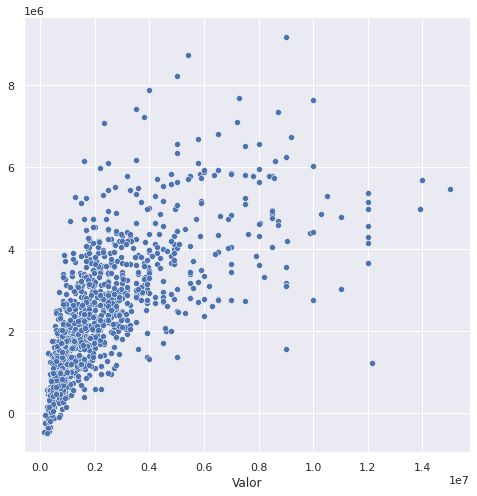

In [ ]:
lr_model(X=imoveis_tratados[['Metragem', 'Quartos', 'Banheiros', 'Vagas','V001','V007', 'V009']],
         Y=imoveis_tratados["Valor"], tittle='Modelo com dados IBGE (Algoritmo)')

## Desafio Aula 5

1 - Adicionar o valor "real" do m2 do imóvel. 

2 - Testar outro modelos de regressão.

3 - Criar um modelo baseline com as features originais.

4 - Trabalhar um pouco mais nos dados e criar novas variáveis.

5 - Testar as predições para casos reais. 

6 - Criar um projeto com os resultados da imersão. Postar nas redes sociais mostrando o trabalho realizado. 

### Outro modelos de regressão.


In [ ]:
from sklearn.linear_model import Lasso

X = imoveis_tratados_manual[['Metragem', 'Quartos', 'Banheiros', 'Vagas','V001','V007', 'V009']]
Y = imoveis_tratados_manual["Valor"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25, random_state = 54)

alpha = 0.1
lasso = Lasso(alpha=alpha)

Y_pred_lasso = lasso.fit(X_train, Y_train).predict(X_test)
r2_score_lasso = r2_score(Y_test, Y_pred_lasso)
print(lasso)
print("r^2 on test data : %f" % r2_score_lasso)

Lasso(alpha=0.1)
r^2 on test data : 0.590603


In [ ]:
from sklearn.linear_model import ElasticNet

X = imoveis_tratados_manual[['Metragem', 'Quartos', 'Banheiros', 'Vagas','V001','V007', 'V009']]
Y = imoveis_tratados_manual["Valor"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25, random_state = 54)
\
alpha = 0.1
enet = ElasticNet(alpha=alpha, l1_ratio=0.7)

Y_pred_enet = enet.fit(X_train, Y_train).predict(X_test)
r2_score_enet = r2_score(Y_test, Y_pred_enet)
print(enet)
print("r^2 on test data : %f" % r2_score_enet)

ElasticNet(alpha=0.1, l1_ratio=0.7)
r^2 on test data : 0.590570


In [ ]:
from sklearn.linear_model import Ridge

X = imoveis_tratados_manual[['Metragem', 'Quartos', 'Banheiros', 'Vagas','V001','V007', 'V009']]
Y = imoveis_tratados_manual["Valor"]


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25, random_state = 54)

clf = Ridge(alpha=1.0)

Y_pred_clf = clf.fit(X_train, Y_train).predict(X_test)
r2_score_clf = r2_score(Y_test, Y_pred_enet)
print(clf)
print("r^2 on test data : %f" % r2_score_clf)

Ridge()
r^2 on test data : 0.590570


GradientBoostingRegressor(learning_rate=0.05, max_depth=8, n_estimators=500,
                          random_state=0)
1269180277814.9038
0.820943330670113


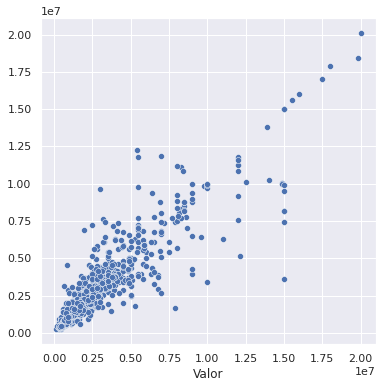

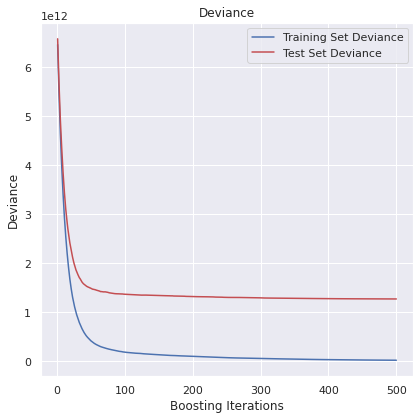

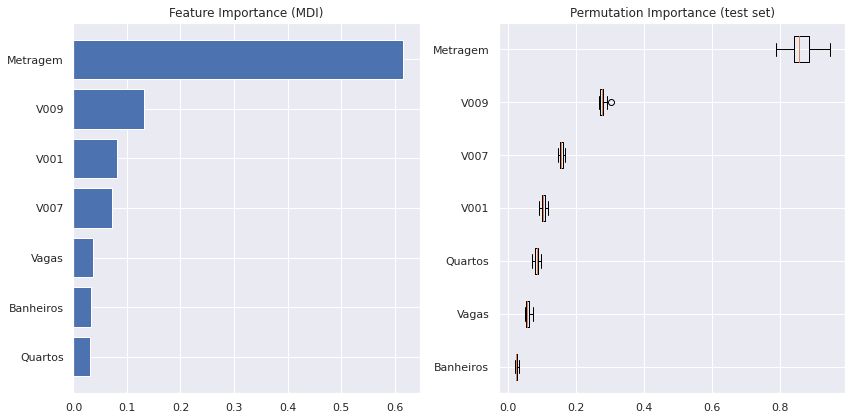

In [ ]:
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance

X = imoveis_tratados_manual[['Metragem', 'Quartos', 'Banheiros', 'Vagas','V001','V007', 'V009']]
Y = imoveis_tratados_manual["Valor"]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25, random_state = 54)

# best --> n_estimators=2500+, learning_rate=0.2, min_samples_split=2, max_depth=10, random_state=0
params = {
    "n_estimators": 500,
    "max_depth": 8,
    "learning_rate": 0.05,
    "loss": "squared_error",
    "random_state": 0
}
reg = GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)


#reg.predict(X_test[1:2])
print(reg)
print(mean_squared_error(y_test, reg.predict(X_test)))
print(reg.score(X_test, y_test))


plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=reg.predict(X_test))
plt.show()


test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(X_test)):
    test_score[i] = reg.loss_(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    reg.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()


feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(['Metragem', 'Quartos', 'Banheiros', 'Vagas','V001','V007', 'V009'])[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    reg, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(['Metragem', 'Quartos', 'Banheiros', 'Vagas','V001','V007', 'V009'])[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

GradientBoostingRegressor(learning_rate=0.05, max_depth=8, n_estimators=500,
                          random_state=0)
mean squared error: 1269180277814.9038
score: 0.820943330670113


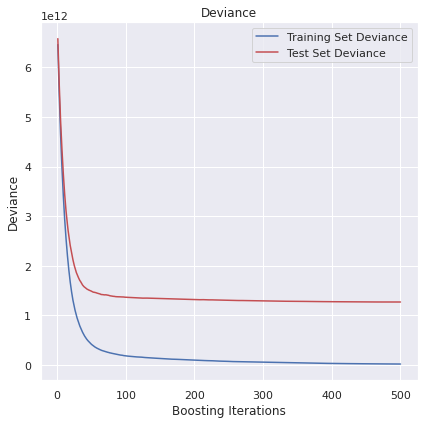

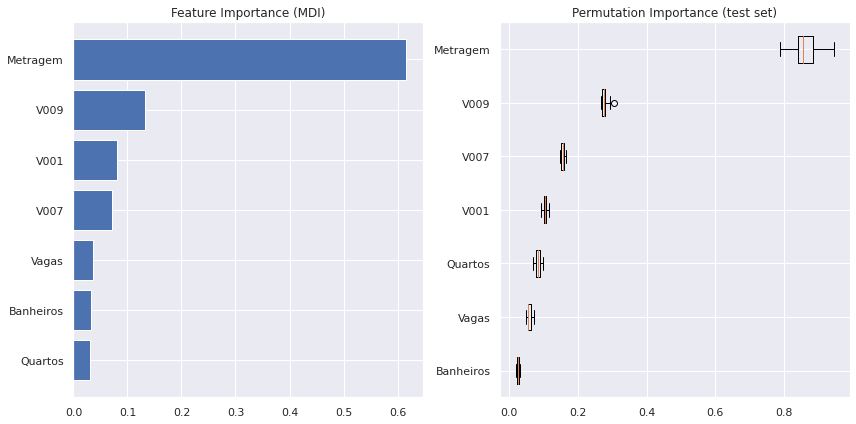

In [ ]:
gbr_model(X = imoveis_tratados_manual[['Metragem', 'Quartos', 'Banheiros', 'Vagas','V001','V007', 'V009']], Y = imoveis_tratados_manual["Valor"])

GradientBoostingRegressor(learning_rate=0.05, max_depth=8, n_estimators=500,
                          random_state=0)
mean squared error: 1461190804892.042
score: 0.7938543772285259


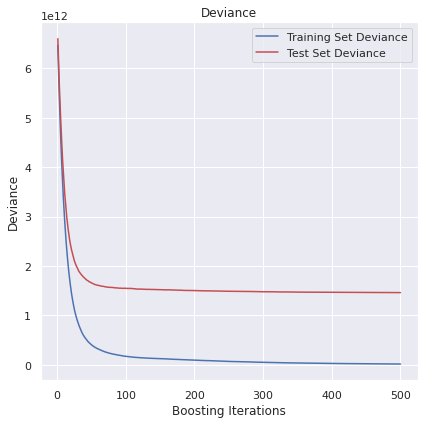

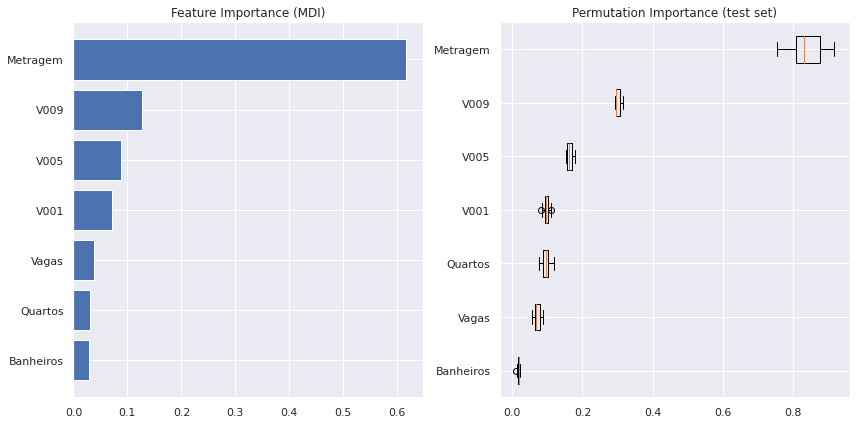

In [ ]:
gbr_model(X = imoveis_tratados_manual[['Metragem','Quartos', 'Banheiros', 'Vagas','V009','V005','V001']],
          Y = imoveis_tratados_manual["Valor"])

### Modelo baseline com as features originais. 
(Valor, Metragem, Quartos, Banheiros, Vagas)

 ----- Modelo com Variaveis Originais -----

\Test Statistics\ 
 - Mean Absolute Error: 1212546.2771112411
 - R2-score: 0.3666769189902179

\Train Statistics\ 
 - Mean Absolute Error: 1155193.8312409834
 - R2-score: 0.3934975501915412


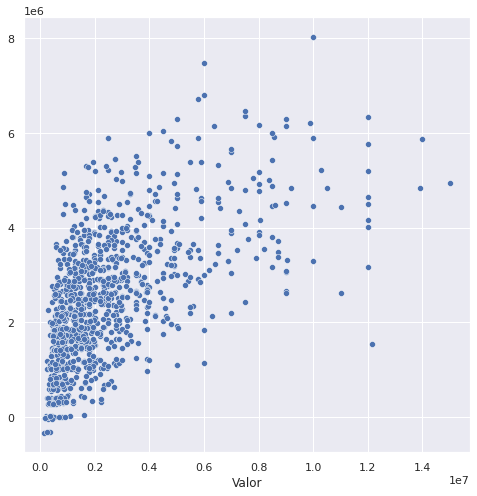

In [ ]:
lr_model(X=imoveis_tratados[['Metragem','Quartos','Banheiros','Vagas']],
         Y=imoveis_tratados["Valor"], tittle='Modelo com Variaveis Originais')

GradientBoostingRegressor(learning_rate=0.05, max_depth=8, n_estimators=500,
                          random_state=0)
mean squared error: 2334247492287.707
score: 0.5226528254685772


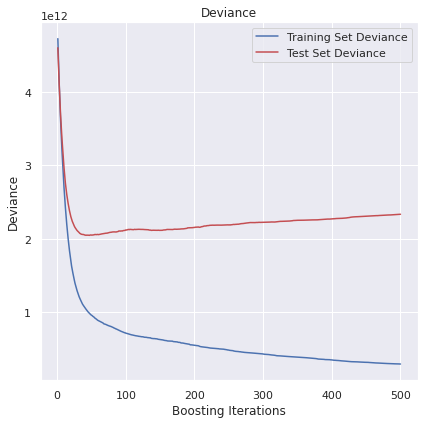

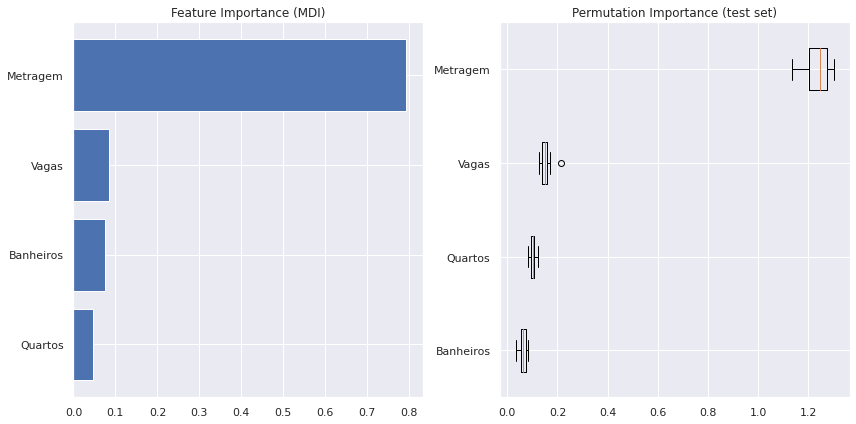

In [7]:
gbr_model(X=imoveis_tratados[['Metragem','Quartos','Banheiros','Vagas']],
          Y=imoveis_tratados["Valor"])

###  Trabalhar um pouco mais nos dados e criar novas variáveis.

In [ ]:
imoveis_new_val = imoveis_tratados_manual.copy(deep=True)

In [ ]:
# imoveis_new_val.insert(loc=9,column='Renda_por_m2',value=(imoveis_new_val.V007 / imoveis_new_val.Metragem)) # Pouca correlacao com Valor
imoveis_new_val.insert(loc=9,column='Morador_por_m2',value=(imoveis_new_val.V003 / imoveis_new_val.Metragem))
imoveis_new_val

,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Valor,Preco_m2,Morador_por_m2,rua_e_bairro,cep,latitude,longitude,Point,setor_censo,Cod_distrito,Nome_do_distrito,Situacao_setor,Tipo_setor,V001,V002,V003,V004,V005,V006,V007,V008,V009,V010,V011,V012
0,"Avenida Itacira, 255",Planalto Paulista,São Paulo,1000,4,8,6,7000000.00,7000.00,0.00,avenida itacira - planalto paulista,4061000.00,-23.62,-46.65,POINT (-46.6481622 -23.6157934),355030877000067.00,355030877.00,SAÚDE,1.00,0.00,164.00,437.00,2.66,2.04,3158.96,22210644.93,5570.65,25770816.97,2096.19,13029851.56,3930.35,17241576.74
1,"Rua Aurelia Perez Alvarez, 42",Jardim dos Estados,São Paulo,496,4,4,4,3700000.00,7459.68,0.01,rua aurelia perez alvarez - jardim dos estados,4642020.00,-23.64,-46.69,POINT (-46.6883114 -23.6409612),355030871000023.00,355030871.00,SANTO AMARO,1.00,0.00,136.00,425.00,3.13,1.96,7600.44,36778930.17,7890.53,35886906.64,4149.00,26760682.90,6063.92,27502674.90
2,Rua Alba Valdez,Jardim Reimberg,São Paulo,125,4,3,2,380000.00,3040.00,0.03,rua alba valdez - jardim reimberg,4845200.00,-23.75,-46.70,POINT (-46.6958895 -23.75299),355030830000050.00,355030830.00,GRAJAÚ,1.00,0.00,142.00,493.00,3.47,3.06,805.13,769188.78,1011.75,757433.42,518.77,426672.78,858.51,414378.88
3,"Rua Tobias Barreto, 195",Mooca,São Paulo,100,3,2,2,540000.00,5400.00,0.03,rua tobias barreto - mooca,3176000.00,-23.55,-46.59,POINT (-46.5881729 -23.5499597),355030808000050.00,355030808.00,BELÉM,1.00,0.00,156.00,468.00,3.00,1.99,2338.05,7826370.15,2447.89,7925839.76,1543.29,4646566.16,1909.04,5050712.69
4,Rua Graham Bell,Santo Amaro,São Paulo,440,4,4,6,1980000.00,4500.00,0.01,rua graham bell - santo amaro,4737030.00,-23.59,-46.76,POINT (-46.7600773 -23.5937964),355030865000169.00,355030865.00,RAPOSO TAVARES,1.00,0.00,107.00,376.00,3.51,2.31,1026.36,272168.67,1143.96,167733.64,735.67,367088.08,1086.94,159622.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4874,Rua Pedro Teixeira,Vila Olímpia,São Paulo,157,3,2,2,960000.00,6114.65,0.01,rua pedro teixeira - vila olímpia,4550010.00,-23.60,-46.68,POINT (-46.6783021 -23.6035167),355030835000027.00,355030835.00,ITAIM BIBI,1.00,0.00,177.00,384.00,2.17,1.27,5054.58,33245189.73,5231.93,33485189.78,3649.06,26562232.53,4551.66,29032823.35
4875,Avenida Odila,Planalto Paulista,São Paulo,267,3,6,4,1500000.00,5617.98,0.01,avenida odila - planalto paulista,4058020.00,-23.61,-46.65,POINT (-46.6472577 -23.6090928),355030877000099.00,355030877.00,SAÚDE,1.00,0.00,256.00,720.00,2.81,1.60,4249.33,24499871.44,5180.14,25047413.33,2618.76,17705032.31,3977.93,21495997.85
4876,Rua Tapuçu,Vila Sofia,São Paulo,95,2,2,2,665000.00,7000.00,0.03,rua tapuçu - vila sofia,4671185.00,-23.66,-46.69,POINT (-46.6915206 -23.661018),355030816000087.00,355030816.00,CAMPO GRANDE,1.00,0.00,150.00,448.00,2.99,1.81,2425.09,6878872.25,2543.80,6913867.79,1561.58,4261814.01,2062.09,4596759.57
4877,Rua Estero Belaco,Vila da Saúde,São Paulo,205,3,3,6,1050000.00,5121.95,0.01,rua estero belaco - vila da saúde,4145020.00,-23.62,-46.63,POINT (-46.632983 -23.6161237),355030877000052.00,355030877.00,SAÚDE,1.00,0.00,400.00,1099.00,2.75,1.50,5650.20,20344622.14,5750.84,20127679.27,3459.68,16021825.60,4362.79,16264378.33


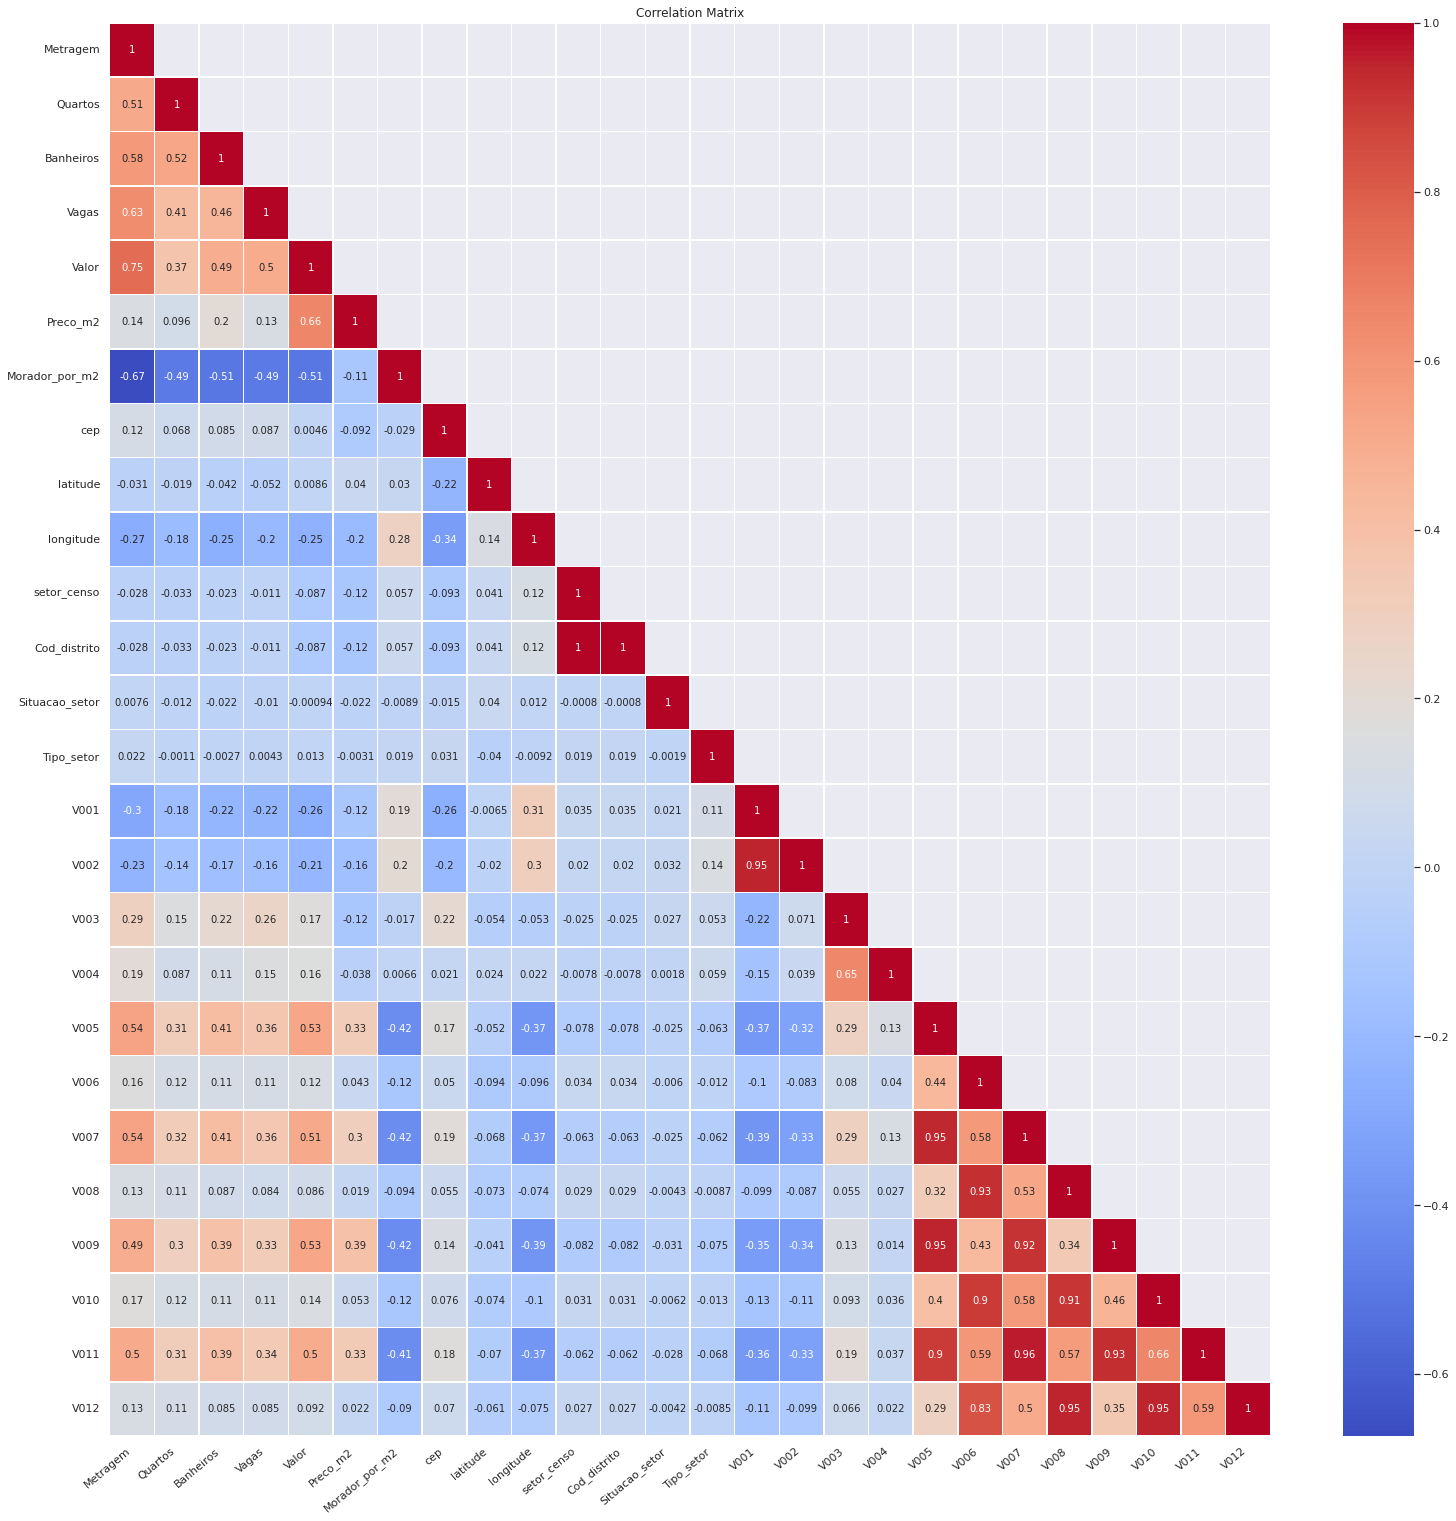

In [ ]:
corr_matrix(imoveis_new_val)

 ----- Modelo com Novas Variaveis -----

\Test Statistics\ 
 - Mean Absolute Error: 967488.1533649818
 - R2-score: 0.5962955791452316

\Train Statistics\ 
 - Mean Absolute Error: 939284.2972345399
 - R2-score: 0.6052217761120229


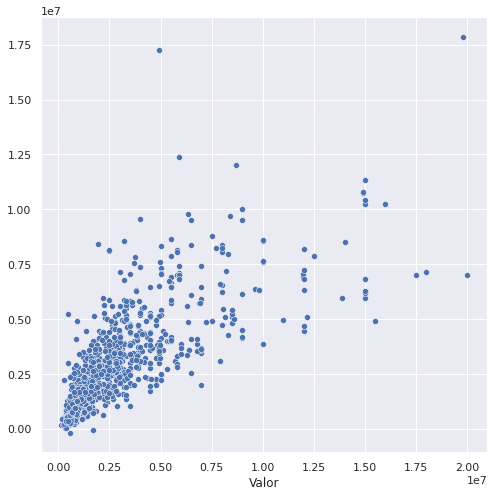

In [ ]:
lr_model(X=imoveis_new_val[['Metragem','Quartos','Banheiros','Vagas','V005','V007','V009','V011','Morador_por_m2']],
         Y=imoveis_new_val["Valor"], tittle='Modelo com Novas Variaveis')

GradientBoostingRegressor(learning_rate=0.05, max_depth=8, n_estimators=500,
                          random_state=0)
mean squared error: 1375687044064.4963
score: 0.8059172960246785


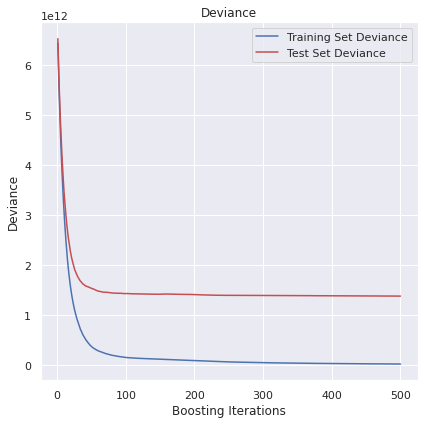

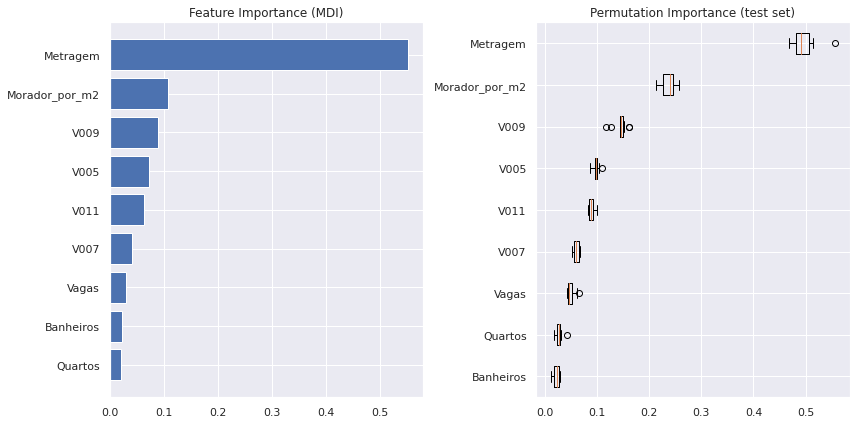

In [ ]:
gbr_model(X=imoveis_new_val[['Metragem','Quartos','Banheiros','Vagas','V005','V007','V009','V011','Morador_por_m2']],
          Y=imoveis_new_val["Valor"])

## Conclusão



Tipo de modelo               | Tipo de Dados                       | R² test Score
-----------------------------|-------------------------------------|---------------------------------------
Linear Regression            | Baseline*                           | 0.36
Linear Regression            | Tratamento de Outlier por Algoritmo | 0.46
Linear Regression            | Tratamento de Outlier Manual        | **0.59**
Gradient Boosting Classifier | Baseline*                           | 0.52
Gradient Boosting Classifier | Tratamento de Outlier por Algoritmo | 0.52
Gradient Boosting Classifier | Tratamento Manual                   | **0.82**            

<br>
Baseline* : Modelo de tratamento de Outlier por Algoritmo utilizando somente variaveis originais do dataset de imoveis


#### É possivel inferir pela tabela acima que os melhores resultados são adquiridos através do tratamento de ouliers e forma manual (por vizualizacao gráficao e contextual), isto pode ser devido a situacões específica em que os algoritmos de detecçãao de outliers uni e multi dimensionais devem ser aplicados, que podem indicar de forma erronea valores muito diferenciados, visto que os dados reais podem ser distorcidos pelo espaço amostral dos dataset de imoveis.


#### Além disso, é observado que o melhor modelo preditivo é obtido atraves do modelo Gradient Boosting Classifier, com um R² test Score de 0,82.